This file contains the code for paper [**Easy Transfer Learning By Exploiting Intra-domain Structures**](https://arxiv.org/pdf/1904.01376.pdf) published at **IEEE International Conference on Multimedia & Expo (ICME) 2019.**

In [240]:
import os
import pulp
import time
import scipy
import seaborn
import scipy.io
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
seaborn.set()

## Intra-domain Programming

Explanation for this function.

In [2]:
def get_class_center(Xs, Ys):
    class_center = []
    classes = np.unique(Ys)

    for c in classes:
        mask = Ys == c
        Xi = Xs[mask.flatten()]
        hc = np.mean(Xi, axis=0)
        class_center.append(hc)

    return np.asarray(class_center)

Explanation for this function.

In [3]:
def get_distance_matrix(Xt, class_center):
    nt = Xt.shape[0]
    C = class_center.shape[0]

    D = np.zeros((C, nt))

    for i, hc in enumerate(class_center):
        for j, xt in enumerate(Xt):
            d = np.linalg.norm(xt - hc)
            D[i][j] = d

    return D

Explanation for this function.

In [4]:
def solve_LP(C, nt, Dcj):

    Dcj = abs(Dcj)
    model = pulp.LpProblem('Cost_minimizing_problem', pulp.LpMinimize)
    Mcj = pulp.LpVariable.dicts('Probabality',
                                ((i, j) for i in range(C) for j in range(nt)),
                                lowBound=0,
                                upBound=1,
                                cat='continous')
    # Objective function
    model += (pulp.lpSum(Dcj[(i, j)] * Mcj[(i, j)] for i in range(C)
                         for j in range(nt)))

    # Constarints
    for j in range(nt):
        model += pulp.lpSum([Mcj[(i, j)] for i in range(C)]) == 1

    for i in range(C):
        model += pulp.lpSum([Mcj[(i, j)] for j in range(nt)]) >= 1

    # Solve the problem
    model.solve()
    pulp.LpStatus[model.status]
    output = [[Mcj[i, j].varValue for i in range(C)] for j in range(nt)]

    return np.array(output)

Explanation for this function.

In [5]:
def intra_domain_programming(Xs, Ys, Xt, Yt):
    C = len(np.unique(Ys))
    nt = len(Yt)

    class_center = get_class_center(Xs, Ys)
    D = get_distance_matrix(Xt, class_center)
    Mcj = solve_LP(C, nt, D)

    y_pred = np.argmax(Mcj, axis=1)
    acc = np.mean(y_pred == Yt.flatten())

    return y_pred, acc

## Intra_domain Alignment

In [6]:
def intra_domain_alignment(Xs, Xt):
    cov_src = np.ma.cov(Xs.T)
    cov_tar = np.ma.cov(Xt.T)

    Es = np.eye(Xs.shape[1])
    Et = np.eye(Xt.shape[1])

    Cs = scipy.linalg.sqrtm(np.linalg.inv(np.array(cov_src + Es)))
    Ct = scipy.linalg.sqrtm(np.array(cov_tar + Et))

    coral = np.dot(Cs, Ct)

    Xs_new = np.dot(Xs, coral)
    return Xs_new

## EasyTL

In [7]:
def EasyTL(Xs, Ys, Xt, Yt):
    Xs = intra_domain_alignment(Xs, Xt)
    y_pred, acc = intra_domain_programming(Xs, Ys, Xt, Yt)

    return y_pred, acc

In [8]:
def EasyTL_without_alignment(Xs, Ys, Xt, Yt):
    y_pred, acc = intra_domain_programming(Xs, Ys, Xt, Yt)

    return y_pred, acc

## Experiments

### Amazon Review dataset

In [274]:
datadir = 'Datasets/amazon_review/'
domain = ['books', 'dvd', 'elec', 'kitchen']
task = []
EasyTL_Acc = []
EasyTL_time = []
EasyTL_without_alignment_Acc = []
EasyTL_without_alignment_time = []

for i in range(len(domain)):
    for j in range(len(domain)):
        if i == j:
            continue
        print("{} - {}".format(domain[i], domain[j]))
        task.append("{} - {}".format(domain[i], domain[j]))
        
        mat1 = scipy.io.loadmat(datadir + '/{}_400.mat'.format(domain[i]))
        mat2 = scipy.io.loadmat(datadir + '/{}_400.mat'.format(domain[j]))

        Xs = mat1['fts']
        Ys = mat1['labels']

        Xt = mat2['fts']
        Yt = mat2['labels']

        Xs = Xs / np.tile(np.sum(Xs, axis=1).reshape(-1, 1), [1, Xs.shape[1]])
        Xs = scipy.stats.mstats.zscore(Xs)
        Xt = Xt / np.tile(np.sum(Xt, axis=1).reshape(-1, 1), [1, Xt.shape[1]])
        Xt = scipy.stats.mstats.zscore(Xt)
        
        Xs[np.isnan(Xs)] = 0
        Xt[np.isnan(Xt)] = 0

        t0 = time.time()
        _, Acc = EasyTL(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_time.append('{:.2f}'.format(t1 - t0))
        
        t0 = time.time()
        _, Acc = EasyTL_without_alignment(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL without alignment Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL without alignment Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_without_alignment_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_without_alignment_time.append('{:.2f}'.format(t1 - t0))  

books - dvd


C:\Users\maryam\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


EasyTL Time Elapsed: 1.71 sec
EasyTL Acc: 79.8 %
EasyTL without alignment Time Elapsed: 0.57 sec
EasyTL without alignment Acc: 78.4 %
books - elec
EasyTL Time Elapsed: 1.73 sec
EasyTL Acc: 79.7 %
EasyTL without alignment Time Elapsed: 0.68 sec
EasyTL without alignment Acc: 77.5 %
books - kitchen
EasyTL Time Elapsed: 1.87 sec
EasyTL Acc: 80.9 %
EasyTL without alignment Time Elapsed: 0.69 sec
EasyTL without alignment Acc: 79.2 %
dvd - books
EasyTL Time Elapsed: 2.27 sec
EasyTL Acc: 79.9 %
EasyTL without alignment Time Elapsed: 0.51 sec
EasyTL without alignment Acc: 79.5 %
dvd - elec
EasyTL Time Elapsed: 2.18 sec
EasyTL Acc: 80.8 %
EasyTL without alignment Time Elapsed: 0.88 sec
EasyTL without alignment Acc: 77.4 %
dvd - kitchen
EasyTL Time Elapsed: 1.94 sec
EasyTL Acc: 82.0 %
EasyTL without alignment Time Elapsed: 0.57 sec
EasyTL without alignment Acc: 80.4 %
elec - books
EasyTL Time Elapsed: 1.96 sec
EasyTL Acc: 75.0 %
EasyTL without alignment Time Elapsed: 0.66 sec
EasyTL without align

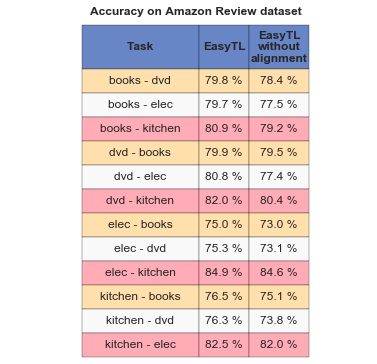

In [275]:
df = pd.DataFrame({
    'Task': task,
    'EasyTL': EasyTL_Acc,
    'EasyTL\nwithout\nalignment': EasyTL_without_alignment_Acc
})[['Task', 'EasyTL', 'EasyTL\nwithout\nalignment']]

table = plt.table(cellText=df.values,
                  colWidths=[0.35, 0.15, 0.18],
                  colLabels=df.columns,
                  cellLoc='center',
                  loc='upper center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

for i in range(0, 3):
    table[(0, i)].set_height(.2)
    table[(0, i)].set_fontsize(12)
    table[(0, i)].set_text_props(fontweight="bold")

for i in range(len(task) + 1):
    for j in range(0, 3):
        if i == 0:
            table[(i, j)].set_facecolor("#6886c5")
        elif i % 3 == 0:
            table[(i, j)].set_facecolor("#ffacb7")
        elif i % 3 == 1:
            table[(i, j)].set_facecolor("#ffe0ac")
        else:
            table[(i, j)].set_facecolor("#f9f9f9")

title = 'Accuracy on Amazon Review dataset'
plt.title(title, fontweight="bold")
plt.axis('off')

plt.savefig(title + '.jpg', bbox_inches="tight", dpi=300)

plt.show()

### Office-Caltech dataset

In [276]:
datadir = 'Datasets/surf/'
domain = ['caltech10', 'amazon', 'webcam', 'dslr']
task = []
EasyTL_Acc = []
EasyTL_time = []
EasyTL_without_alignment_Acc = []
EasyTL_without_alignment_time = []

for i in range(len(domain)):
    for j in range(len(domain)):
        if i == j:
            continue
            
        print("{} - {}".format(domain[i], domain[j]))
        task.append("{} - {}".format(domain[i], domain[j]))
        
        mat1 = scipy.io.loadmat(datadir + '/{}_SURF_L10.mat'.format(domain[i]))
        mat2 = scipy.io.loadmat(datadir + '/{}_SURF_L10.mat'.format(domain[j]))

        Xs = mat1['fts']
        Ys = mat1['labels'] - 1

        Xt = mat2['fts']
        Yt = mat2['labels'] - 1

        Xs = Xs / np.tile(np.sum(Xs, axis=1).reshape(-1, 1), [1, Xs.shape[1]])
        Xs = scipy.stats.mstats.zscore(Xs)
        Xt = Xt / np.tile(np.sum(Xt, axis=1).reshape(-1, 1), [1, Xt.shape[1]])
        Xt = scipy.stats.mstats.zscore(Xt)

        Xs[np.isnan(Xs)] = 0
        Xt[np.isnan(Xt)] = 0

        t0 = time.time()
        _, Acc = EasyTL(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_time.append('{:.2f}'.format(t1 - t0))
        
        t0 = time.time()
        _, Acc = EasyTL_without_alignment(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL without alignment Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL without alignment Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_without_alignment_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_without_alignment_time.append('{:.2f}'.format(t1 - t0))  

caltech10 - amazon
EasyTL Time Elapsed: 4.92 sec
EasyTL Acc: 52.6 %
EasyTL without alignment Time Elapsed: 1.30 sec
EasyTL without alignment Acc: 50.1 %
caltech10 - webcam
EasyTL Time Elapsed: 4.96 sec
EasyTL Acc: 53.9 %
EasyTL without alignment Time Elapsed: 0.49 sec
EasyTL without alignment Acc: 49.5 %
caltech10 - dslr
EasyTL Time Elapsed: 3.68 sec
EasyTL Acc: 51.6 %
EasyTL without alignment Time Elapsed: 0.19 sec
EasyTL without alignment Acc: 48.4 %
amazon - caltech10
EasyTL Time Elapsed: 5.25 sec
EasyTL Acc: 42.3 %
EasyTL without alignment Time Elapsed: 1.57 sec
EasyTL without alignment Acc: 43.0 %
amazon - webcam
EasyTL Time Elapsed: 3.79 sec
EasyTL Acc: 43.1 %
EasyTL without alignment Time Elapsed: 0.38 sec
EasyTL without alignment Acc: 40.7 %
amazon - dslr
EasyTL Time Elapsed: 3.59 sec
EasyTL Acc: 48.4 %
EasyTL without alignment Time Elapsed: 0.22 sec
EasyTL without alignment Acc: 38.9 %
webcam - caltech10
EasyTL Time Elapsed: 4.15 sec
EasyTL Acc: 35.4 %
EasyTL without alignment

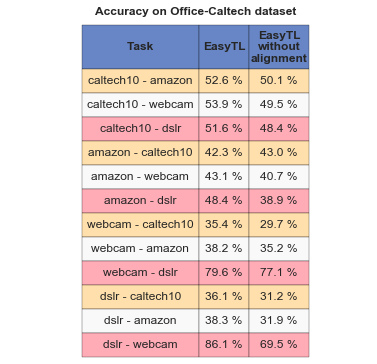

In [277]:
df = pd.DataFrame({
    'Task': task,
    'EasyTL': EasyTL_Acc,
    'EasyTL\nwithout\nalignment': EasyTL_without_alignment_Acc
})[['Task', 'EasyTL', 'EasyTL\nwithout\nalignment']]

table = plt.table(cellText=df.values,
                  colWidths=[0.35, 0.15, 0.18],
                  colLabels=df.columns,
                  cellLoc='center',
                  loc='upper center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

for i in range(0, 3):
    table[(0, i)].set_height(.2)
    table[(0, i)].set_fontsize(12)
    table[(0, i)].set_text_props(fontweight="bold")

for i in range(len(task) + 1):
    for j in range(0, 3):
        if i == 0:
            table[(i, j)].set_facecolor("#6886c5")
        elif i % 3 == 0:
            table[(i, j)].set_facecolor("#ffacb7")
        elif i % 3 == 1:
            table[(i, j)].set_facecolor("#ffe0ac")
        else:
            table[(i, j)].set_facecolor("#f9f9f9")

title = 'Accuracy on Office-Caltech dataset'
plt.title(title, fontweight="bold")
plt.axis('off')

plt.savefig(title + '.jpg', bbox_inches="tight", dpi=300)

plt.show()

### Image-CLEF DA dataset

In [255]:
domain = ['c', 'i', 'p']
datadir = 'Datasets/imageCLEF_resnet50/'
task = []
EasyTL_Acc = []
EasyTL_time = []
EasyTL_without_alignment_Acc = []
EasyTL_without_alignment_time = []

for i in range(len(domain)):
    for j in range(len(domain)):
        if i == j:
            continue
        print("{} - {}".format(domain[i], domain[j]))
        task.append("{} - {}".format(domain[i], domain[j]))
        
        src = domain[i]
        tar = domain[j]

        x1file = "{}_{}.csv".format(src, src)
        x2file = "{}_{}.csv".format(src, tar)

        df1 = pd.read_csv(os.path.join(datadir, x1file), header=None)
        Xs = df1.values[:, :-1]
        Ys = df1.values[:, -1]

        df2 = pd.read_csv(os.path.join(datadir, x2file), header=None)
        Xt = df2.values[:, :-1]
        Yt = df2.values[:, -1]

        Xs = Xs / np.tile(np.sum(Xs, axis=1).reshape(-1, 1), [1, Xs.shape[1]])
        Xs = scipy.stats.mstats.zscore(Xs)
        Xt = Xt / np.tile(np.sum(Xt, axis=1).reshape(-1, 1), [1, Xt.shape[1]])
        Xt = scipy.stats.mstats.zscore(Xt)

        t0 = time.time()
        _, Acc = EasyTL(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_time.append('{:.2f}'.format(t1 - t0))
        
        t0 = time.time()
        _, Acc = EasyTL_without_alignment(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL without alignment Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL without alignment Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_without_alignment_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_without_alignment_time.append('{:.2f}'.format(t1 - t0)) 

c - i
EasyTL Time Elapsed: 31.34 sec
EasyTL Acc: 91.5 %
EasyTL without alignment Time Elapsed: 1.01 sec
EasyTL without alignment Acc: 85.5 %
c - p
EasyTL Time Elapsed: 31.70 sec
EasyTL Acc: 77.7 %
EasyTL without alignment Time Elapsed: 1.11 sec
EasyTL without alignment Acc: 72.0 %
i - c
EasyTL Time Elapsed: 31.19 sec
EasyTL Acc: 96.0 %
EasyTL without alignment Time Elapsed: 0.90 sec
EasyTL without alignment Acc: 93.3 %
i - p
EasyTL Time Elapsed: 31.03 sec
EasyTL Acc: 78.7 %
EasyTL without alignment Time Elapsed: 1.33 sec
EasyTL without alignment Acc: 78.5 %
p - c
EasyTL Time Elapsed: 30.08 sec
EasyTL Acc: 95.0 %
EasyTL without alignment Time Elapsed: 0.98 sec
EasyTL without alignment Acc: 91.0 %
p - i
EasyTL Time Elapsed: 30.78 sec
EasyTL Acc: 90.3 %
EasyTL without alignment Time Elapsed: 1.41 sec
EasyTL without alignment Acc: 89.5 %


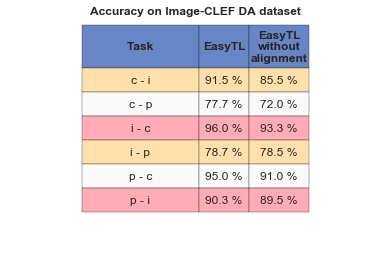

In [273]:
df = pd.DataFrame({
    'Task': task,
    'EasyTL': EasyTL_Acc,
    'EasyTL\nwithout\nalignment': EasyTL_without_alignment_Acc
})[['Task', 'EasyTL', 'EasyTL\nwithout\nalignment']]

table = plt.table(cellText=df.values,
                  colWidths=[0.35, 0.15, 0.18],
                  colLabels=df.columns,
                  cellLoc='center',
                  loc='upper center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

for i in range(0, 3):
    table[(0, i)].set_height(.2)
    table[(0, i)].set_fontsize(12)
    table[(0, i)].set_text_props(fontweight="bold")

for i in range(len(task) + 1):
    for j in range(0, 3):
        if i == 0:
            table[(i, j)].set_facecolor("#6886c5")
        elif i % 3 == 0:
            table[(i, j)].set_facecolor("#ffacb7")
        elif i % 3 == 1:
            table[(i, j)].set_facecolor("#ffe0ac")
        else:
            table[(i, j)].set_facecolor("#f9f9f9")

title = 'Accuracy on Image-CLEF DA dataset'
plt.title(title, fontweight="bold")
plt.axis('off')

plt.savefig(title + '.jpg', bbox_inches="tight", dpi=300)

plt.show()

### Office-Home dataset

In [12]:
# not implemented yet